In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [3]:
# clean_dataset_kaggle.py
from pathlib import Path
import shutil

# Read-only dataset root
ROOT = Path("/kaggle/input/paytm-logo-detection")

# Writable output root
OUT_ROOT = Path("/kaggle/working/paytm-clean")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

sets = ["train", "valid", "test"]

for s in sets:
    img_dir = ROOT / s / "images"
    label_dir = ROOT / s / "labels"
    if not img_dir.exists() or not label_dir.exists():
        print(f"Skipping {s}, path missing")
        continue

    out_img_dir = OUT_ROOT / s / "images"
    out_lab_dir = OUT_ROOT / s / "labels"
    out_img_dir.mkdir(parents=True, exist_ok=True)
    out_lab_dir.mkdir(parents=True, exist_ok=True)

    for img in img_dir.glob("*.*"):
        lbl = label_dir / f"{img.stem}.txt"
        # keep only if label file exists and is not empty
        if lbl.exists() and lbl.stat().st_size > 0:
            shutil.copy2(img, out_img_dir / img.name)
            shutil.copy2(lbl, out_lab_dir / lbl.name)

    print(f"{s}: copied labeled images to {out_img_dir}")


train: copied labeled images to /kaggle/working/paytm-clean/train/images
valid: copied labeled images to /kaggle/working/paytm-clean/valid/images
test: copied labeled images to /kaggle/working/paytm-clean/test/images


In [4]:
# attribute_encoder.py
from pathlib import Path
from PIL import Image
import shutil

ROOT = Path("/path/to/dataset")
threshold_full = 0.25  # bounding box area fraction of image -> treat as full

def convert_set(s):
    img_dir = ROOT / s / "images"
    label_dir = ROOT / s / "labels"
    out_label_dir = ROOT / s / "labels_attr"
    out_label_dir.mkdir(parents=True, exist_ok=True)
    for lab in label_dir.glob("*.txt"):
        img_path = img_dir / (lab.stem + ".jpg")
        if not img_path.exists():
            img_path = img_dir / (lab.stem + ".png")
            if not img_path.exists():
                continue
        w,h = Image.open(img_path).size
        new_lines = []
        with open(lab,'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls, x_c, y_c, bw, bh = parts[:5]
                bwf = float(bw) * w
                bhf = float(bh) * h
                area_frac = (float(bw) * float(bh))
                # Heuristic: if bbox covers > threshold_full fraction of image -> full
                if area_frac >= threshold_full:
                    new_cls = 0  # paytm_full
                else:
                    new_cls = 1  # paytm_partial
                # Save as YOLO format: class x y w h
                new_lines.append(f"{new_cls} {x_c} {y_c} {bw} {bh}\n")
        with open(out_label_dir / lab.name, "w") as fo:
            fo.writelines(new_lines)

for s in ["train","valid","test"]:
    convert_set(s)

print("Converted attribute labels to class-per-attribute in labels_attr folders.")


Converted attribute labels to class-per-attribute in labels_attr folders.


In [5]:
# augment_dataset.py (fixed)
import os
from pathlib import Path
import albumentations as A
import cv2
import uuid

ROOT = Path("/kaggle/working/paytm-clean")  # use the cleaned dataset
SET = "train"
IMG_DIR = ROOT / SET / "images"
LAB_DIR = ROOT / SET / "labels"
OUT_IMG = ROOT / SET / "images_aug"
OUT_LAB = ROOT / SET / "labels_aug"
OUT_IMG.mkdir(parents=True, exist_ok=True)
OUT_LAB.mkdir(parents=True, exist_ok=True)

# Updated transforms: no Cutout, use CoarseDropout instead
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,
                       rotate_limit=15, p=0.6, border_mode=cv2.BORDER_CONSTANT),
    A.RandomCrop(width=640, height=640, p=0.3),
    A.CoarseDropout(
        min_holes=1, max_holes=8,
        min_height=8, max_height=32,
        min_width=8, max_width=32,
        fill_value=0, p=0.5
    ),
], bbox_params=A.BboxParams(format='yolo',
                             label_fields=['category_ids'],
                             min_visibility=0.3))


copies_per_image = 3

def read_labels(lbl_path):
    bboxes, cats = [], []
    with open(lbl_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, x, y, w, h = parts[:5]
            bboxes.append([float(x), float(y), float(w), float(h)])
            cats.append(int(cls))
    return bboxes, cats

for img_path in IMG_DIR.glob("*.*"):
    lab_path = LAB_DIR / (img_path.stem + ".txt")
    if not lab_path.exists():
        continue
    image = cv2.imread(str(img_path))
    bboxes, cats = read_labels(lab_path)
    if len(bboxes) == 0:
        continue
    for i in range(copies_per_image):
        transformed = transform(image=image, bboxes=bboxes, category_ids=cats)
        img_t = transformed['image']
        bboxes_t = transformed['bboxes']
        cats_t = transformed['category_ids']
        if len(bboxes_t) == 0:
            continue
        out_name = f"{img_path.stem}_aug_{uuid.uuid4().hex[:8]}.jpg"
        cv2.imwrite(str(OUT_IMG / out_name), img_t)
        with open(OUT_LAB / (Path(out_name).stem + ".txt"), "w") as fo:
            for cls_id, box in zip(cats_t, bboxes_t):
                x, y, w_, h_ = box
                fo.write(f"{cls_id} {x:.6f} {y:.6f} {w_:.6f} {h_:.6f}\n")

print("Augmentation finished. Augmented images in", OUT_IMG)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_36/4089076119.py:24: UserWarning: Argument(s) 'min_holes, max_holes, min_height, max_height, min_width, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Augmentation finished. Augmented images in /kaggle/working/paytm-clean/train/images_aug


In [6]:
from pathlib import Path
import shutil

ROOT = Path("/kaggle/working/paytm-clean")  # your cleaned dataset root

train_img = ROOT / "train" / "images"
train_lab = ROOT / "train" / "labels"
aug_img = ROOT / "train" / "images_aug"
aug_lab = ROOT / "train" / "labels_aug"

# Safety: create backup folders if needed
backup_img = ROOT / "train" / "images_backup"
backup_lab = ROOT / "train" / "labels_backup"
backup_img.mkdir(exist_ok=True)
backup_lab.mkdir(exist_ok=True)

print("Merging augmented data into train set...")

# Copy augmented images
for img_file in aug_img.glob("*.*"):
    dst = train_img / img_file.name
    if dst.exists():
        shutil.copy2(img_file, backup_img / img_file.name)  # backup if name clash
    shutil.copy2(img_file, train_img / img_file.name)

# Copy augmented labels
for lab_file in aug_lab.glob("*.txt"):
    dst = train_lab / lab_file.name
    if dst.exists():
        shutil.copy2(lab_file, backup_lab / lab_file.name)  # backup if name clash
    shutil.copy2(lab_file, train_lab / lab_file.name)

print("✅ Merge complete. YOLO can now use train/images and train/labels directly.")


Merging augmented data into train set...
✅ Merge complete. YOLO can now use train/images and train/labels directly.


In [7]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 model
model = YOLO("yolov8n.pt")

# 1) Train with backbone frozen (use first 10 layers as frozen)
model.train(
    data="/kaggle/input/paytm-logo-detection/data.yaml",
    epochs=15,
    imgsz=640,
    batch=8,
    lr0=1e-3,
    name="paytm_yolov8_freezehead",
    exist_ok=True,
    freeze=10        # <--- freeze first 10 layers
)

# 2) Fine-tune all layers (no freezing)
model.train(
    data="/kaggle/input/paytm-logo-detection/data.yaml",
    epochs=30,
    imgsz=640,
    batch=8,
    lr0=1e-4,
    name="paytm_yolov8_finetune",
    exist_ok=True,
    freeze=0         # <--- unfreeze everything
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.198 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/paytm-logo-detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         47         35      0.431      0.576      0.619      0.276
         fully_visible          7         17      0.316      0.882      0.792      0.398
     partially_visible         10         18      0.547      0.269      0.447      0.155
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /kaggle/working/runs/detect/paytm_yolov8_freezehead
Ultralytics 8.3.198 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/paytm-logo-detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         47         35      0.694      0.637       0.71      0.309
         fully_visible          7         17      0.555      0.941      0.876      0.441
     partially_visible         10         18      0.833      0.333      0.544      0.176
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/paytm_yolov8_finetune


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a65cf5cbe90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [8]:
from ultralytics import YOLO
import glob

# find last "best.pt" produced
best_path = sorted(glob.glob("/kaggle/working/runs/detect/*/weights/best.pt"))[-1]
print("Best model:", best_path)

# load for inference
model = YOLO(best_path)


Best model: /kaggle/working/runs/detect/paytm_yolov8_freezehead/weights/best.pt



image 1/1 /kaggle/working/paytm-clean/test/images/INDIA-VS-WEST-INDIES-T20-FINAL-MATCH-FULL-MATCH-HIGHLIGHTS-_-IND-VS-WI-MOST-THRILLING-EVER-online-video-cutter_com-_mp4-0654_jpg.rf.fcf926dfd1102cbe495607e1e1ffd1dc.jpg: 640x640 1 fully_visible, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


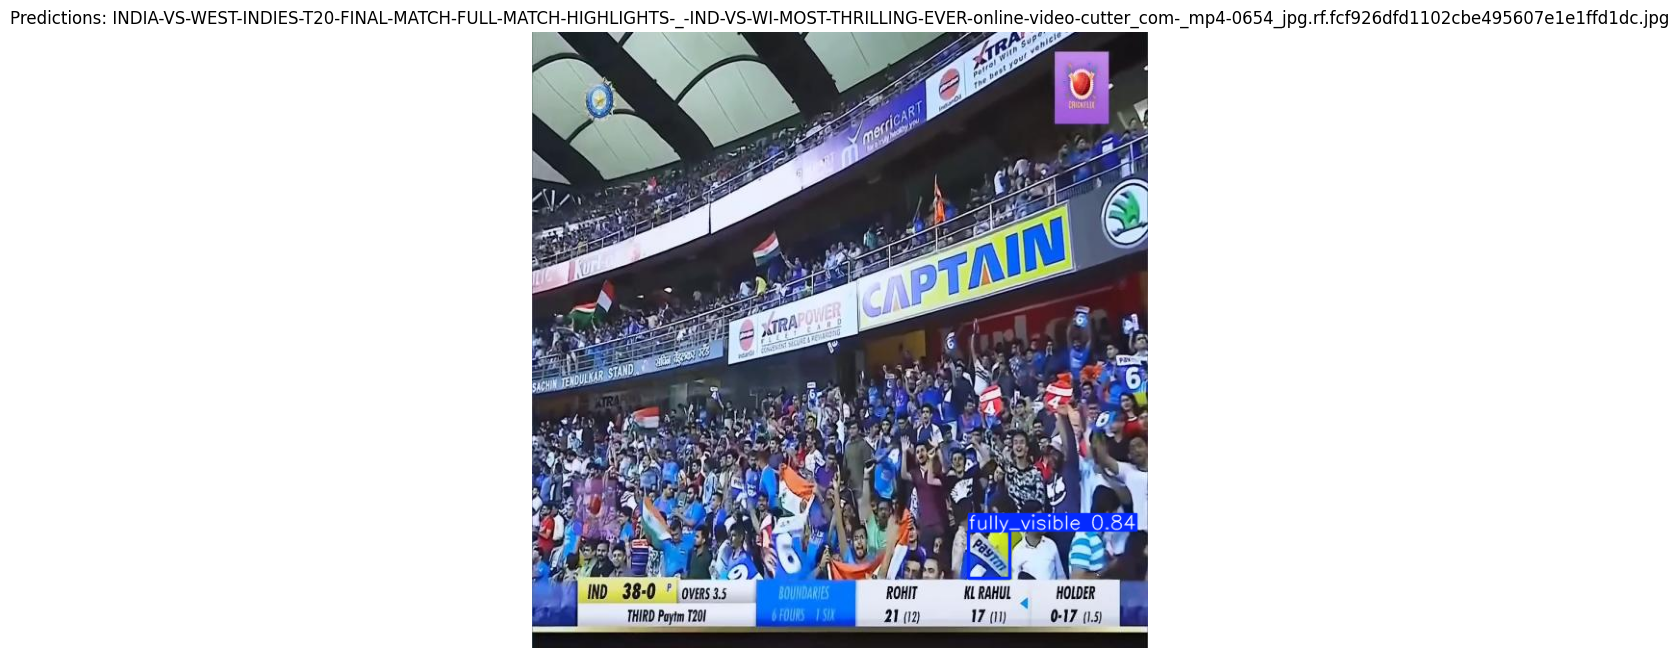


image 1/1 /kaggle/working/paytm-clean/test/images/INDIA-VS-WEST-INDIES-T20-FINAL-MATCH-FULL-MATCH-HIGHLIGHTS-_-IND-VS-WI-MOST-THRILLING-EVER-online-video-cutter_com-_mp4-0656_jpg.rf.6e254d81550b8725cb92a2a630d371a5.jpg: 640x640 1 fully_visible, 10.5ms
Speed: 2.0ms preprocess, 10.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


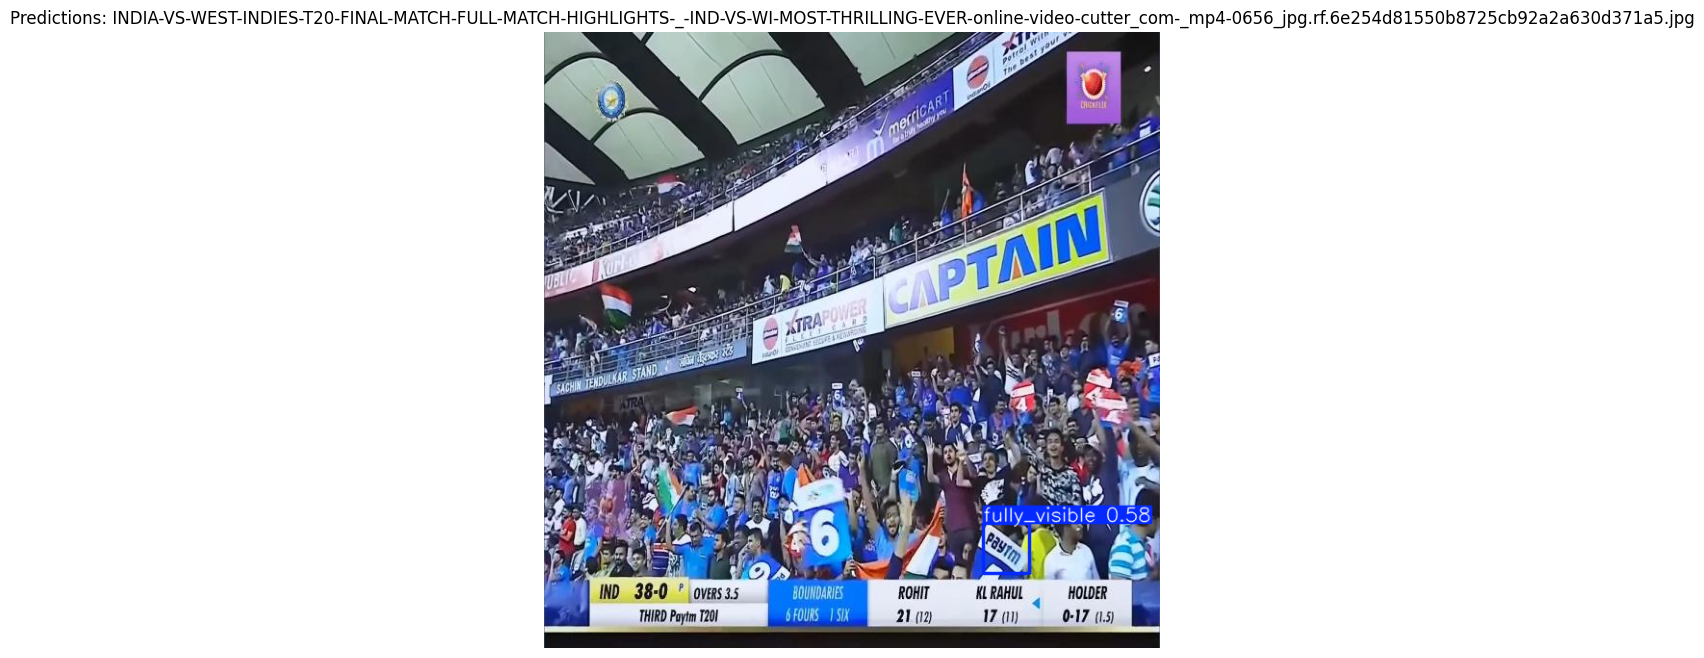


image 1/1 /kaggle/working/paytm-clean/test/images/INDIA-VS-WEST-INDIES-T20-FINAL-MATCH-FULL-MATCH-HIGHLIGHTS-_-IND-VS-WI-MOST-THRILLING-EVER-online-video-cutter_com-_mp4-0086_jpg.rf.0f5fe8468c35d68a17b1d2a2b1d287f8.jpg: 640x640 1 fully_visible, 2 partially_visibles, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


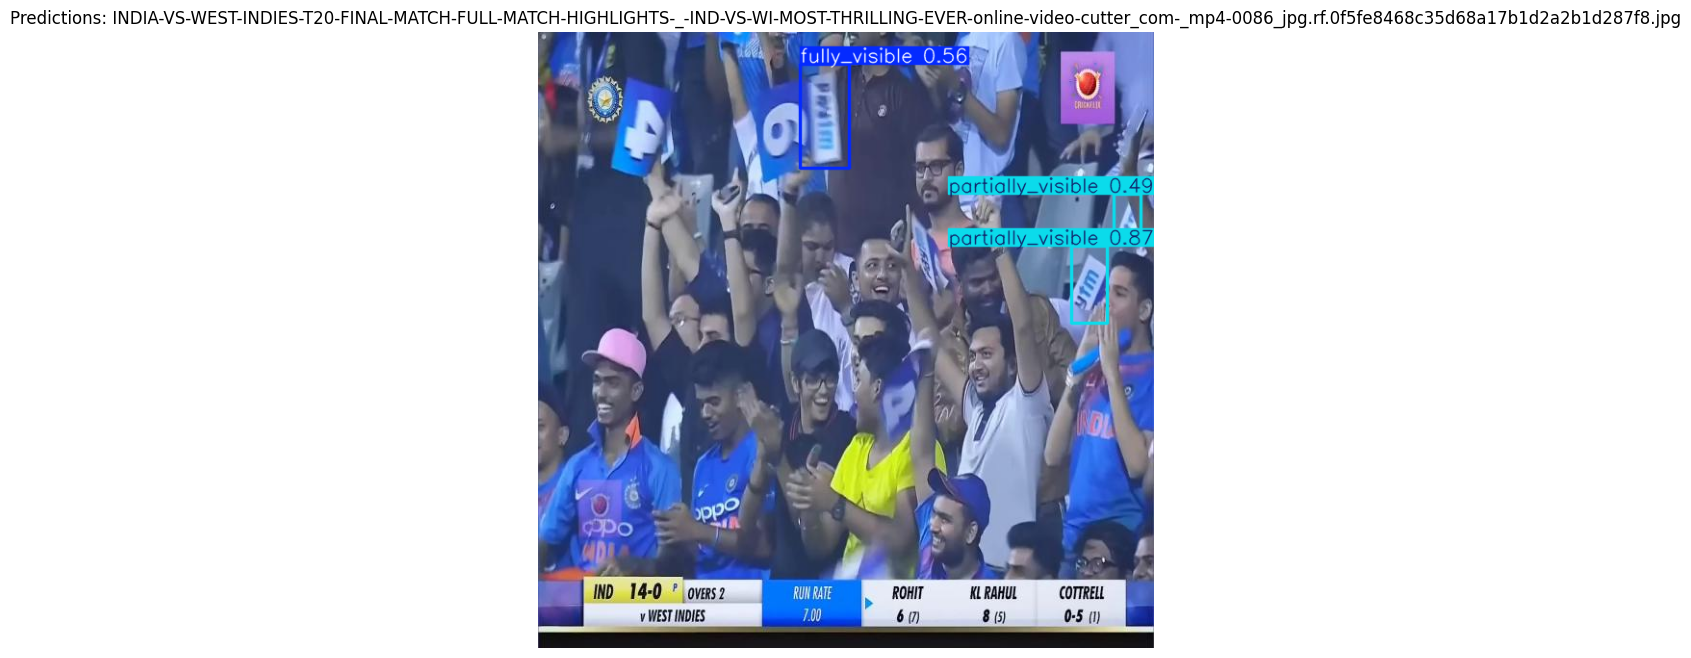


image 1/1 /kaggle/working/paytm-clean/test/images/INDIA-VS-WEST-INDIES-T20-FINAL-MATCH-FULL-MATCH-HIGHLIGHTS-_-IND-VS-WI-MOST-THRILLING-EVER-online-video-cutter_com-_mp4-0333_jpg.rf.151d25f4f51196b9429bebc974204546.jpg: 640x640 1 fully_visible, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


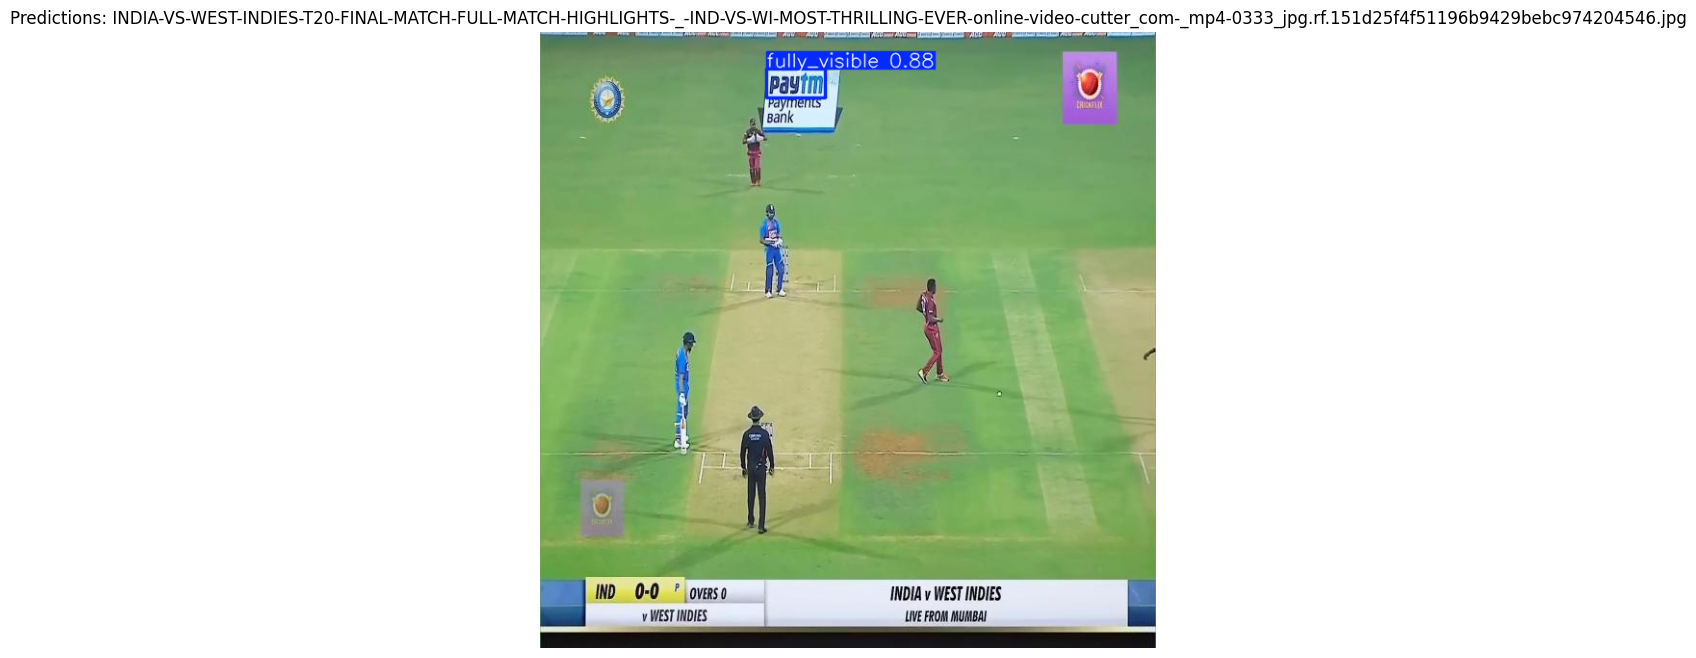


image 1/1 /kaggle/working/paytm-clean/test/images/INDIA-VS-WEST-INDIES-T20-FINAL-MATCH-FULL-MATCH-HIGHLIGHTS-_-IND-VS-WI-MOST-THRILLING-EVER-online-video-cutter_com-_mp4-0326_jpg.rf.c916f7f0e7bc66f1fe8bea88e3fd7bc6.jpg: 640x640 1 fully_visible, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


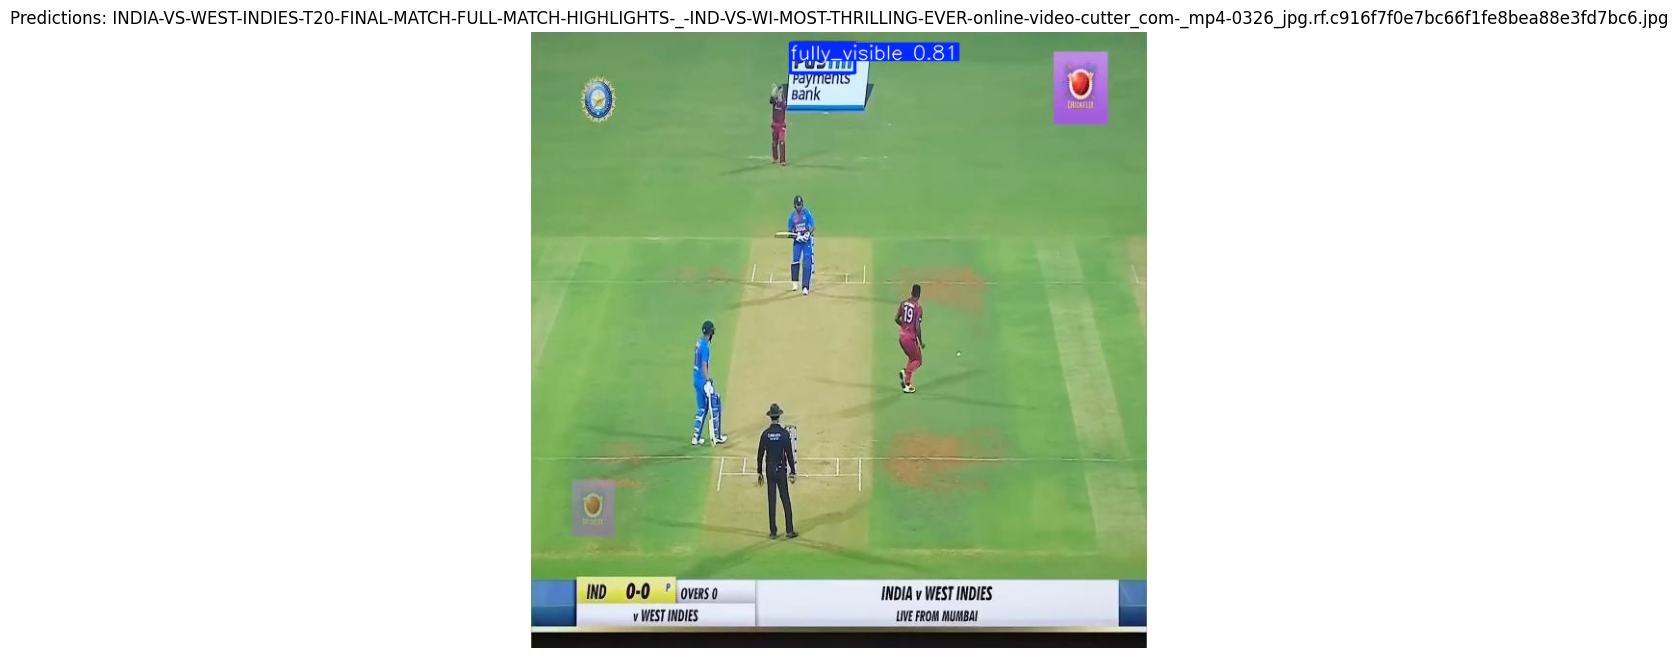

In [9]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

TEST_IMG_DIR = Path("/kaggle/working/paytm-clean/test/images")

# Pick a few test images to show
for img_path in list(TEST_IMG_DIR.glob("*.*"))[:5]:  # show first 5 images
    res = model.predict(img_path, imgsz=640, conf=0.25, device=0)
    im = res[0].plot()  # Ultralytics has built-in plotting

    # Convert BGR (OpenCV) -> RGB (matplotlib)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(im_rgb)
    plt.axis("off")
    plt.title(f"Predictions: {img_path.name}")
    plt.show()
